In [93]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/asl-alphabet


In [112]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [114]:
DATASET_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

categories = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
num_classes = len(categories)
print("Number of classes:", num_classes)
print("Classes:", categories)


Number of classes: 29
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


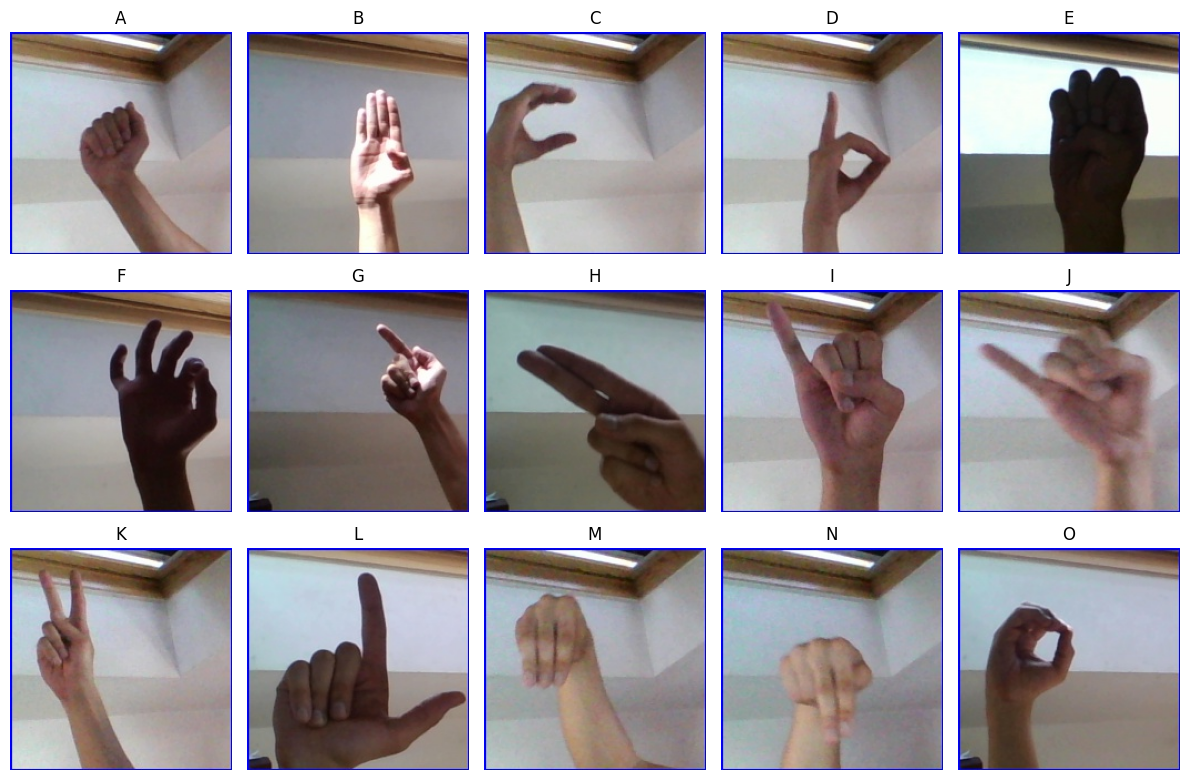

In [121]:
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()

for i, category in enumerate(categories[:15]):  
    category_path = os.path.join(DATASET_PATH, category)
    if not os.path.isdir(category_path):
        continue
    img_list = os.listdir(category_path)
    if not img_list:
        print(f"Warning: No images found in {category_path}")
        continue
    img_path = os.path.join(category_path, img_list[0])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Unable to read image at {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [122]:
IMG_SIZE = 64  

def load_data():
    images = []
    labels = []
    
    for category in categories:
        category_path = os.path.join(DATASET_PATH, category)
        if not os.path.isdir(category_path):
            continue
        label = categories.index(category)
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
            if img is None:
                print(f"Warning: Unable to read image at {img_path}")
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

X, y = load_data()

X = X / 255.0  
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  

y = to_categorical(y, num_classes)


In [123]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training data size:", X_train.shape)
print("Testing data size:", X_test.shape)
print("Validation data size:", X_val.shape)


Training data size: (69600, 64, 64, 1)
Testing data size: (8700, 64, 64, 1)
Validation data size: (8700, 64, 64, 1)


In [133]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [134]:
model = Sequential()
model.add(Input(shape=(64, 64, 1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

In [135]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Reshape((1, 128))) 

In [136]:
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))

In [137]:
num_classes = 29  
model.add(Dense(num_classes, activation='softmax'))

In [138]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 29)                  │           1,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 733,917 (2.80 MB)

 Trainable params: 733,917 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [141]:
epochs = 20  
batch_size = 32

In [142]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [143]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.3259 - loss: 2.2827 - val_accuracy: 0.8799 - val_loss: 0.4013
Epoch 2/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8733 - loss: 0.4169 - val_accuracy: 0.9557 - val_loss: 0.1397
Epoch 3/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9589 - loss: 0.1497 - val_accuracy: 0.9856 - val_loss: 0.0498
Epoch 4/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9775 - loss: 0.0854 - val_accuracy: 0.9889 - val_loss: 0.0333
Epoch 5/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9790 - loss: 0.0708 - val_accuracy: 0.9928 - val_loss: 0.0243
Epoch 6/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9879 - loss: 0.0432 - val_accuracy: 0.9874 - val_loss: 0.0369
Epoch 7/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9885 - loss: 0.0406 - val_accuracy: 0.9962 - val_loss: 0.0134
Epoch 8/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9914 - loss: 0

In [144]:
model.save("asl_cnn_lstm_model.h5")
print("Model saved successfully!")

Model saved successfully!


In [145]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
class_labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "del", "nothing", "space"]


In [150]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [151]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 99.90%


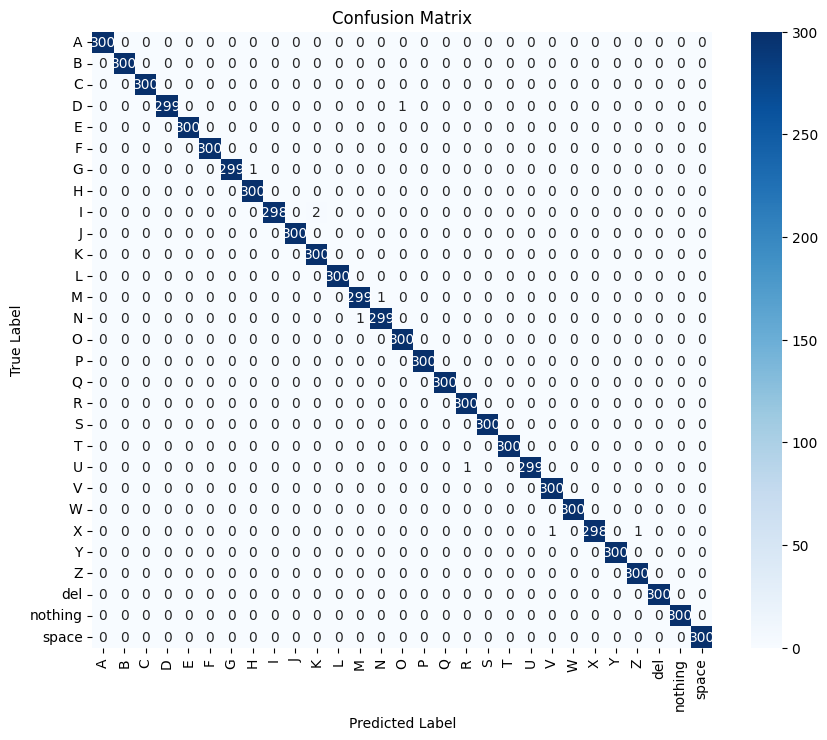

In [152]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

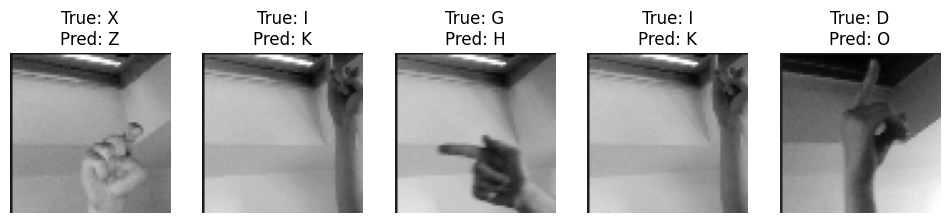

In [154]:
misclassified_idx = np.where(y_pred != y_true)[0]
num_misclassified = min(5, len(misclassified_idx))  

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified_idx[:num_misclassified]):
    plt.subplot(1, num_misclassified, i + 1)
    plt.imshow(X_test[idx].reshape(64, 64), cmap='gray')
    plt.title(f"True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}")
    plt.axis("off")
plt.show()